# Building a predictive model - Part II

[4. Model & Assess (Modelling and Assessment)](#1st-bullet)<br>
- [4.1. Model Selection](#2nd-bullet)<br>
    - [4.1.1. Compare different algorithms and select the most promising ones](#3rd-bullet)<br>
- [4.2. Model Optimization](#4th-bullet)<br>
    - [4.2.1. K-Nearest Neighbors](#5th-bullet)<br>
    - [4.2.2. Decision Trees](#6th-bullet)<br>
        - [4.2.2.1. How to visualize decision trees](#7th-bullet)<br>
    - [4.2.3. Neural Networks](#8th-bullet)<br>
    - [4.2.4. RandomizedSearchCV](#9th-bullet)<br>
    - [4.2.5. GridSearchCV](#10th-bullet)<br>
    - [4.2.6. Select the winner model](#11th-bullet)<br>
        - [4.2.6.1. Compare the performance](#12th-bullet)<br>
        - [4.2.6.2. Plot a ROC Curve](#13th-bullet)<br>
        - [4.2.6.3. Change the threshold](#14th-bullet)<br>
        
[5. Deploy](#15th-bullet)<br>
- [5.1. Import your test data and apply transformations](#16th-bullet)<br>
- [5.2. Obtain Predictions on the test data from your final model](#17th-bullet)<br>
- [5.3. Create a Dataframe containing the index of each row and its intended prediction and export it to a csv file](#18th-bullet)<br>

<a class="anchor" id="1st-bullet">

# 4. Model & Assess (Modelling and Assessment)

</a>
<img src="Images/step4.png" style="height:70px">

<div class="alert alert-block alert-success">

<a class="anchor" id="2nd-bullet">

## 4.1. Model Selection
    
</div></a>

In this section you should take the time to train different predictive algorithms with the data that got to this stage and **use the approppriate model assessment metrics to decide which model you think is the best to address your problem**.

**You are expected to present on your report the model performances of the different algorithms that you tested and discuss what informed your choice for a specific algorithm**

__`Step 01`__ Import all the needed libraries:

- MinMaxScaler from sklearn.preprocessing

- LogisticRegression from sklearn.linear_model
- KNeighborsClassifier from sklearn.neighbors
- DecisionTreeClassifier from sklearn.tree
- MLPClassifier from sklearn.neural_network <br><br>

- f1_score from sklearn.metrics
- roc_curve from sklearn.metrics
- precision_recall_curve from sklearn.metrics <br><br>

- StratifiedKFold from sklearn.model_selection
- train_test_split from sklearn.model_selection
- GridSearchCV from sklearn.model_selection
- RandomizedSearchCV from sklearn.model_selection 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

############################################## PREPROCESSING ##############################################
from sklearn.preprocessing import MinMaxScaler

################################################# MODELS ##################################################
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

################################################# METRICS #################################################
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

################################### MODEL SELECTION & OPTIMIZATION ########################################
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

######################################### DECISION TREES PLOTS ############################################
# in anaconda prompt: conda install python-graphviz
#!pip install pydotplus
from sklearn.tree import export_graphviz
import graphviz
import pydotplus

__`Step 02`__ From the feature selection steps on the previous class, we obtained two different data sets, one called `keep_data` and another named as `all_data`. Import those data sets.

In [2]:
keep_data = pd.read_excel(r'keep_data.xlsx')
all_data = pd.read_excel(r'all_data.xlsx')

At this point, we have two data sets to test:
- `keep_data`- This dataset is composed by the most important variables defined by the feature selection techniques applied previously. It is composed by: <br><br>
    - Mnt, Clothes, NetPurchase, Marital_status, DepVar<br><br>
- `all_data` - This dataset is composed by the most important variables defined by the feature selection techniques applied previously, but also with the variables that we are in doubt to use. It is composed by:<br><br>
    - Mnt, Clothes, NetPurchase, Marital_status, Rcn, SmallAppliances, Toys, Recomendation, DepVar

__NOTE ABOUT PREPROCESSING:__ <br>
Concerning the variable `Marital_Status`:
- It has misclassifications
- It has missing values
- Is a categorical variable and we need to convert it to a numerical one

Furthermore, the models we are going to apply (except decision trees) are sensible to scaling issues. We need to scale our data accordingly.

__`Step 03`__ Create a function called `transform_data` that will receive one or two datasets and make the following changes in the categorical data:

In the training data:
- Fill missing data in Marital_status with the mode from the training data
- Replace 'BigConfusion' to the most frequent value from the training data
- Replace 'Together' to 'Married'
- Create dummies on your data set, and drop one possible column (for example 'Marital_Status_widow')

If you have a second data set (validation or test):
- Fill missing data in your second data set in Marital_Status with the mode from the training data
- Replace 'BigConfusion' in your second data set to the most frequent value on the training data
- Replace 'Together' to 'Married'
- Create dummies on your data set, and drop the same column that you dropped on the training data set.

__NOTE ABOUT USING DUMMIES WITH pandas.dummies__ <br>
When you are creating dummies in your data, it is possible that one class appears on your training data, but not on your second data set (or on the other way around).
Take as example:
- In your training data, you have a column named 'Animals' with the possible values 'Cat','Dog','Turtle','Goat'. When applying dummies, you are going to create 4 new columns and you should drop one of those to avoid multicollinearity, like for example 'Turtle'.
- In your second data set, you have also a column named 'Animals', but this time with the possible values 'Cat','Dog','Turtle'. When applying dummies, you are just going to create 3 new columns and remove 'Turtle'. In this data set, you are not going to have a column named as 'Goat', and this is going to generate an error.

One possible way to solve this is to understand wich columns are different from your training data and your second data set. All the columns that are missing are going to be created and filled with zeros. Then, you just need to ensure that the order of the columns is the same in both data sets.


In [3]:
def transform_data(X_train, X_2nd_df = False, X_2nd_df_flag = False):
    
    ####################################### FILL MISSING DATA #################################################
    # Fill missing values (mode in categorical data)
    X_train['Marital_Status'].fillna(X_train['Marital_Status'].mode(), inplace = True)
    
    #################################### CORRECT MISCLASSIFICAIONS ############################################
    # Correct misclassifications in the Marital Status in training data
    X_train['Marital_Status'] = X_train['Marital_Status'].replace('BigConfusion',X_train['Marital_Status'].mode()[0])
    X_train['Marital_Status'] = X_train['Marital_Status'].replace('Together','Married')
    
    ########################################## CREATE DUMMIES #################################################    
    # Create dummies and remove one of the variables (to avoid multicollinearity)
    X_train_dummies = pd.get_dummies(X_train)
    X_train_dummies.drop('Marital_Status_Widow', axis = 1, inplace = True)
   
    ############################################ SCALE DATA ###################################################    
    scaler = MinMaxScaler().fit(X_train_dummies)
    X_train_scaled = scaler.transform(X_train_dummies)
    X_train_scaled = pd.DataFrame(X_train_scaled , columns = X_train_dummies.columns)
    
    if X_2nd_df_flag == True:
        ####################################### FILL MISSING DATA ############################################# 
        # Now we fill the missing values in validation data set, using the information available in train
        X_2nd_df['Marital_Status'].fillna(X_train['Marital_Status'].mode(), inplace = True)
        
        #################################### CORRECT MISCLASSIFICAIONS ########################################
        # Correct misclassifications in the Marital Status in validation data
        X_2nd_df['Marital_Status'] = X_2nd_df['Marital_Status'].replace('BigConfusion',X_train['Marital_Status'].mode()[0])
        X_2nd_df['Marital_Status'] = X_2nd_df['Marital_Status'].replace('Together','Married')
        
        ########################################## CREATE DUMMIES #############################################
        X_2nd_df_dummies = pd.get_dummies(X_2nd_df)
        X_2nd_df_dummies.drop('Marital_Status_Widow', axis = 1, inplace = True)
        
        # If we don't have all the values in the validation dataset that we have in the train, that column will not be created
        # We should assure that all columns in train are also present in validation
        # Get missing columns from the training dataset
        missing_cols = set(X_train_dummies.columns ) - set(X_2nd_df_dummies.columns )
        # Add a missing column in test set with default value equal to 0
        for c in missing_cols:
            X_2nd_df_dummies[c] = 0
        # Ensure the order of column in the test set is in the same order than in train set
        X_2nd_df_dummies = X_2nd_df_dummies[X_train_dummies.columns]
        
        if 'DepVar' in X_2nd_df_dummies.columns:
            X_2nd_df_dummies.drop(['DepVar'], axis=1, inplace=True)
        else:
            pass
        
        ############################################ SCALE DATA ###################################################    
        X_2nd_df_scaled = scaler.transform(X_2nd_df_dummies) # Scaling with 'scaler' from train data
        X_2nd_df_scaled = pd.DataFrame(X_2nd_df_scaled , columns = X_2nd_df_dummies.columns, index = X_2nd_df_dummies.index )
        
   
    if X_2nd_df_flag == False:
        return X_train_scaled
    else:
        return X_train_scaled, X_2nd_df_scaled

__`Step 04`__ Create a function named as `select_best_models` that will receive as arguments your data set and an instance of a model and:
- Create an instance of StratifiedKFold with 5 splits, `random_state = 99` and `shuffle = True` named as `skf`.
- Define as `X` your independent variables and `y`your target.
- Create two empty lists named as `score_train` and `score_val` that will receive the performances of the model for train and for validation.

- Inside the loop of the StratifiedKFold:
    - Create the dataframes that will correspond to your training data and your validation data at each iteration.
    - Call the function defined previously named `transform_data` to do all the needed changes on the data.
    - Fit your model to the training data.
    - Obtain the predictions of your model in the training data and save those in an object named as `predictions_train`
    - Obtain the predictions of your model in the validation data and save those in an object named as `predictions_val`
    - Append to the list `score_train` the f1-score obtained in your training data set.
    - Append to the list `score_val` the f1-score obtained in your validation data set.

- After all the iterations on the StratifiedKFold:
    - Calculate the mean and the standard deviation of the performance of the models in the training data.
    - Calculate the mean and the standard deviation of the performance of the models in the validation data.

- Return those results.



In [4]:
def select_best_models(data, model):
    skf = StratifiedKFold(n_splits = 5, random_state = 99, shuffle = True)
    X = data.drop('DepVar', axis = 1)
    y = data['DepVar'].copy()
    score_train, score_val = [],[]
        
    # perform the cross-validation    
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        # Change categorical data - call function "transform_data"
        X_train, X_val = transform_data(X_train, X_val, X_2nd_df_flag = True)
        
        # Apply model
        model.fit(X_train, y_train)
        predictions_train = model.predict(X_train)
        predictions_val = model.predict(X_val)
        score_train.append(f1_score(y_train, predictions_train))
        score_val.append(f1_score(y_val, predictions_val))

    avg_train = round(np.mean(score_train),3)
    avg_val = round(np.mean(score_val),3)
    std_train = round(np.std(score_train),2)
    std_val = round(np.std(score_val),2)

    return avg_train, std_train, avg_val, std_val

__`Step 05`__ Create a function called `show_results` that will receive as arguments:
- A dataframe to be filled with the results
- Your data set
- One or more instances of models.

Inside this function, you are going to create a loop where for each model you receive as argument:
- you are going to obtain the average and the standard deviation of the performance in train and in validation by calling the function `select_best models`, passing as arguments your data and the instance of your model.
- Fill the dataframe with those values.

In [5]:
def show_results(df, data, *args):
    count = 0
    # for each instance of model passed as argument
    for arg in args:
        avg_train, std_train, avg_val, std_val = select_best_models(data, arg)
        # store the results in the right row
        df.iloc[count] = str(avg_train) + '+/-' + str(std_train), str(avg_val) + '+/-' + str(std_val)
        count+=1
    return df

<a class="anchor" id="3rd-bullet">

<div class="alert alert-block alert-warning">

### 4.1.1. Compare different algorithms and select the most promising ones  
    
</div></a>


__`Step 06`__ The first thing we are going to do is to compare the performance of different algorithms with the default parameters. The only exceptions on the hyperparameters are:
- The decision tree will be tested with max_depth = 3 <br>
        - __*Why?*__ Decision Trees by default are going to grow until full depth on the training data set. This will lead to situations of overfitting. <br> <br>
- The neural network will be tested with max_iterations = 2000 <br>
        - __*Why?*__ By default, the neural networks will run for only 200 iterations, which can be a small value for the majority of the situations. <br> <br>
        
- __`Step 5.1.`__ Create an instance of a LogisticRegression named as `model_LR`
- __`Step 5.2.`__ Create an instance of a KNeighborsClassifier named as `model_KNN`
- __`Step 5.3.`__ Create an instance of a DecisionTreeClassifier named as `model_DT`. Define `max_depth = 3` and `random_state = 99`
- __`Step 5.4.`__ Create an instance of a MLPClassifier named as `model_NN`. Define `max_iter = 2000` and `random_state = 99`


In [6]:
model_LR = LogisticRegression()
model_KNN = KNeighborsClassifier()
model_DT = DecisionTreeClassifier(max_depth = 3, random_state = 99)
model_NN = MLPClassifier(max_iter = 2000, random_state = 99)

__`Step 07`__ Create a Dataframe with the columns `['Train', 'Validation]` and the index `['Logistic Regression','KNN','DT','NN']` named as `df_all`.

In [7]:
df_all = pd.DataFrame(columns = ['Train','Validation'], index = ['Logistic Regression','KNN','DT','NN'])

__`Step 08`__ Call the function `show_results` and pass as arguments:
- The dataframe `df_all` - This will store the results from the different models;
- The data set `all_data`- This is the data we are going to use to train and validate the different models;
- The models `model_LR`, `model_KNN`, `model_DT` and `model_NN`.

In [8]:
show_results(df_all, all_data, model_LR, model_KNN, model_DT, model_NN)

,Train,Validation
Logistic Regression,0.264+/-0.03,0.229+/-0.08
KNN,0.447+/-0.02,0.235+/-0.06
DT,0.402+/-0.09,0.268+/-0.14
NN,0.349+/-0.04,0.256+/-0.08


__`Step 09`__ Similarly to what you have done on Step 07, now create a Dataframe called `df_keep`. 

In [9]:
df_keep = pd.DataFrame(columns = ['Train','Validation'], index = ['Logistic Regression','KNN','DT','NN'])

__`Step 10`__ Call the function `show_results` and pass as arguments:
- The dataframe `df_keep` - This will store the results from the different models;
- The data set `keep_data`- This is the data we are going to use to train and validate the different models;
- The models `model_LR`, `model_KNN`, `model_DT` and `model_NN`.

In [10]:
show_results(df_keep, keep_data, model_LR, model_KNN, model_DT, model_NN)

,Train,Validation
Logistic Regression,0.261+/-0.02,0.203+/-0.09
KNN,0.448+/-0.02,0.269+/-0.07
DT,0.393+/-0.04,0.355+/-0.07
NN,0.335+/-0.02,0.291+/-0.08


__CONCLUSION:__
- By comparing the results when using the dataset `all_data` and `keep_data`, it seems that the last one leads to better results on validation data set, except on the Logistic Regression. <br><br>
- The __best models__ in validation are, in descending order:
    - Decision Tree, with an f1-score of 0.355
    - Neural Network, with an f1-score of 0.291
    - K-Nearest Neighbors, with an f1-score of 0.269
    - Logistic Regression, with an f1-score of 0.203
    <br><br>
    
- Considering __overfitting__:
    - K-Nearest Neighbors is the model with more overfitting, with a difference between train and validation of around 0.179;
    - Logistic Regression is the second model that suffers more from overfitting, with a difference between train and validation of around 0.058;
    - Neural Network has a difference between train and validation of around 0.044;
    - Decision Tree is the model that suffers less from overfitting, with a difference between train and validation of around 0.038;
    
Decision Trees seems to be the most promising model, followed by Neural Networks and K-Nearest Neighbors.
    
Usually in this phase, after testing several algorithms, we choose the most promising ones and try to optimize them, in order to select the winner model. <br>

As so, we are going to reject at this point the Logistic Regression and try to improve the remaining ones.

<div class="alert alert-block alert-success">

<a class="anchor" id="4th-bullet">

## 4.2. Model Optimization
    
</div></a>

After selecting the best algorithm (set of algorithms), you can try to optimize the performance of your model by fiddling with the algorithms' hyper-parameters and select the options that result on the best overall performance.

Possible ways of doing this can be through:
1. Manual optimization
2. [GridSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
3. [RandomSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)


We are going to compare the f1-score for different algorithms with different hyperparameters in train and validation dataset. We can use a pointplot from seaborn to plot the results. <br>

__`Step 11`__ Create a function called `point_plot` that receives as arguments: <br>
- The results from the training data (`train`)<br>
- The results from the validation data (`validation`)<br>
- A list of the different values tested as hyperparameters (`values_try`). <br> <br>
    
Inside the function, we are going to create two pointplots (`sns.pointplot`):<br>
- One where the x axis will be equal to the `values_try`, the y will represent the training results, the `color = teal` and the `label = Train`.<br>
- One where the x axis will be equal to the `values_try`, the y will represent the validation results, the `color = goldenrod` and the `label = Validation`.<br>
- Call the command plt.legend() to add a legend to the plot.
    

In [11]:
def point_plot(train, validation, values_try):
    sns.pointplot(x=values_try, y=train, color = 'teal', label = 'Train')
    sns.pointplot(x=values_try, y=validation, color = 'goldenrod', label = 'Validation')
    plt.legend()

<div class="alert alert-block alert-info">
    
<a class="anchor" id="4th-bullet">

### 4.2.1. K-Nearest Neighbor
    
</a>
    
<b>class sklearn.neighbors.KNeighborsClassifier</b>(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
</div>

In K-Nearest Neighbor, the hyperparameter `n_neighbors` define the number of neighbors to take into consideration. 
Having a small value of neighbors in k-nearest neighbors (KNN) algorithm typically leads to overfitting and using a large value of k in KNN tends to result in smoother decision boundaries and can lead to underfitting.

__`Step 12`__ Create a function called `get_models_knn` that receives as parameters the data set you want to use and a list of values of different number of neighbors. <br>
Inside this function you will:
- create an empty dictionary called `models` that will receive several instances of models.
- create three empty lists: `results_train`, `results_val` and `names`

For each value of neighbors:
- Create an instance of a KNeighborsClassifier with `n_neighbors = value`. This will be an element on the dictionary, where the key is the name of the model and the value is the instance itself.

For each entry / instance of model you have in your dictionary:
- run the function select_best_models and get the average value of the performance for train, validation, and the name of the model.

In [12]:
def get_models_knn(data, values):
    models = dict()
    results_train, results_val = [],[]
    
    # create the instances of each model with different values
    for value in values:
        models['neighbors_' + str(value)] = KNeighborsClassifier(n_neighbors = value)
        
    for name, model in models.items():
        avg_train, std_train, avg_val, std_val = select_best_models(data, model)
        results_train.append(avg_train)
        results_val.append(avg_val)

    print(results_train)
    print(results_val)
        
        
    return results_train, results_val

__`Step 13`__ In this step:
- Define a list of number of neighbors to test, namely [1,3,5,7,9,11]. 
- Call the function previously defined `get_models_knn` passing as arguments your data set and the list of neighbors.
- Call the function `point_plot`passing as arguments the results of the training data set, the results of the validation data set and the values of neighbors that you try.

[1.0, 0.583, 0.448, 0.402, 0.362, 0.324]
[0.266, 0.282, 0.269, 0.215, 0.188, 0.149]


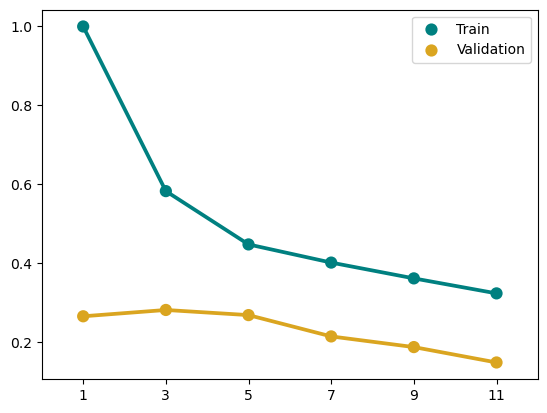

In [13]:
values_try = [1,3,5,7,9,11]
results_train, results_val = get_models_knn(keep_data, values_try)
point_plot(results_train, results_val, values_try)

__CONCLUSION__: <br>
It seems that the best value of number of neighbors to keep is 5 neighbors.

__`Step 14`__ - Create an instance of the model chosen for the algorithm KNN named as `final_model_knn`.

In [14]:
final_model_knn = KNeighborsClassifier(n_neighbors = 5)

__OTHER IMPORTANT HYPERPARAMETERS:__

|Parameter| Definition | Options | Default | 
|---|---|---|---|
| weights| Weight function used in prediction. | Uniform, Distance | Uniform |
| algorithm | Algorithm used to compute the nearest neighbors. | ball_tree, kd_tree, brute, auto | auto |
| metric | Metric to use for distance computation. | Callable | Euclidean Distance |

<div class="alert alert-block alert-info">
    
<a class="anchor" id="6th-bullet">

### 4.2.2. Decision Trees
    
</a>
    
<b>class sklearn.tree.DecisionTreeClassifier</b>(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0)
</div>

In Decision Trees, the hyperparameter `max_depth` define the number of levels our decision tree is going to have. Usually, a higher value leads to overfitting and a lower value to underfitting.

__`Step 15`__ Simillarly to what was done in Step 12, for the function `get_models_knn`, this time create a function to Decision Trees called `get_models_dt`. Instead of applying a KNeighborsClassifier with `n_neighbors = value`, we are going to test different depths of the decision tree with `max_depth = value`.

In [15]:
def get_models_dt(data, values):
    models = dict()
    results_train, results_val = [],[]
    
    # create the instances of each model with different values
    for value in values:
        models['depth_' + str(value)] = DecisionTreeClassifier(max_depth = value, random_state = 99)
        
    for name, model in models.items():
        avg_train, std_train, avg_val, std_val = select_best_models(data, model)
        results_train.append(avg_train)
        results_val.append(avg_val)
        
    return results_train, results_val

__`Step 16`__ In this step:
- Define a list of number of maximum depths to test, namely [1,2,3,4,5,6,7,8,9]. 
- Call the function previously defined `get_models_dt` passing as arguments your data set and the list of depths.
- Call the function `point_plot`passing as arguments the results of the training data set, the results of the validation data set and the values of depths that you try.

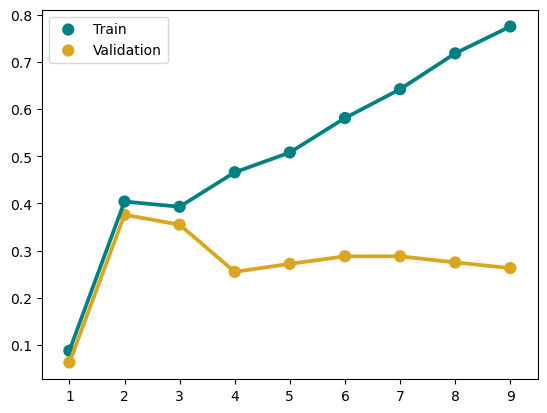

In [16]:
values_try = [1,2,3,4,5,6,7,8,9]
results_train, results_val = get_models_dt(keep_data, values_try)
point_plot(results_train, results_val, values_try)

__CONCLUSION__: <br>
It seems that the best value of levels to keep is 2 levels.

__`Step 17`__ Create an instance of the model chosen for the algorithm DecisionTree named as `final_model_dt`.

In [17]:
final_model_dt = DecisionTreeClassifier(max_depth = 2, random_state = 99)

<a class="anchor" id="7th-bullet">

#### 4.2.2.1. ADDITIONAL: HOW TO VISUALIZE TREES
    
</a>

To visualize a decision tree, you need to create just one single model. For that, we are going to use train_test_split to apply an holdout method.

In [18]:
data = keep_data.copy()

X = data.drop(['DepVar'], axis = 1)
y = data['DepVar'].copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 99, stratify = y)
X_train, X_val = transform_data(X_train, X_val, X_2nd_df_flag = True)

In [19]:
def plot_tree(model):
    dot_data = export_graphviz(model,
                               feature_names=X_train.columns,
                               filled=True)
    pydot_graph = pydotplus.graph_from_dot_data(dot_data)
    pydot_graph.set_size('"20,20"')
    return graphviz.Source(pydot_graph.to_string())

In [20]:
dt_visual = DecisionTreeClassifier(max_depth = 2, random_state = 99).fit(X_train, y_train)

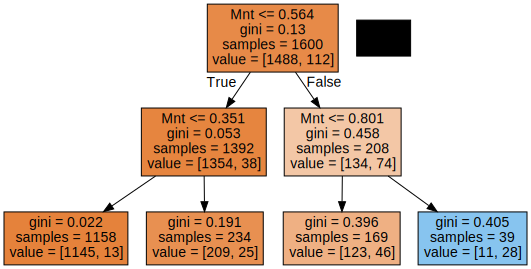

In [21]:
plot_tree(dt_visual)

It seems that a DecisionTree with max_depth = 2 (which is the best model we achieve by testing different numbers of levels) use only the variable `Mnt` to do the splits. <br>
Probably this configuration is not the best to define as the best model from all the algorithms.

__OTHER IMPORTANT HYPERPARAMETERS:__

|Parameter| Definition | Options | Default | Approach | 
|---|---|---|---|---|
| criterion| The function to measure the quality of a split. | gini, entropy, log_loss | gini | - |
| min_samples_split | The minimum number of samples required to split an internal node. | _int_ or _float_ | 2 | Prepruning technique |
| min_samples_leaf | The minimum number of samples required to be at a leaf node.  | _int_ or _float_ | 1 |Prepruning technique |
| max_leaf_nodes | The maximum number of leafs the tree can have.   | _int_ | None |Prepruning technique |
| min_impurity_decrease | A node will be split if it induces a decrease of the impurity greater than or equal to this value. | _float_ | 0.0 | Prepruning technique |
| ccp_alpha | Complexity parameter used for Minimal Cost-Complexity Pruning. | _float_ | 0.0 | Postpruning technique |
| splitter | The strategy used to choose the split at each node. If random,  the algorithm selects a random subset of features and finds the best split among them. | _best_ or _random_ | _best_| Overfitting |
| max_features | The number of features to consider when looking for the best split. | _int_, _float_, _sqrt_, ... | None | Overfitting |

<div class="alert alert-block alert-info">
    
<a class="anchor" id="8th-bullet">

### 4.2.3. Neural Networks
    
</a>

    
<b>class sklearn.neural_network.MLPClassifier</b>(hidden_layer_sizes=(100,), activation='relu', *, solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)
</div>

In Neural Networks, the hyperparameter `hidden_layer_sizes` define the number hidden layers and hidden neurons in our network. Usually, increasing the number of neurons and layers leads to overfitting while a small value of neurons leads to underfitting.

__`Step 18`__ Similarly to what you have done for KNeighborsClassifier and DecisionTreeClassifier, this time we are going to create a function called `get_models_nn` where we are going to change the number of neurons and layers inside a Neural Network, by changing the hyperparameter `hidden_layer_sizes`. Define also `max_iter = 2000` and `random_state = 99`.

In [22]:
def get_models_nn(data, values):
    models = dict()
    results_train, results_val, names = [],[],[]
    
    # create the instances of each model with different values
    for value in values:
        models[str(value)] = MLPClassifier(hidden_layer_sizes = value, max_iter = 2000, random_state = 99)
        
    for name, model in models.items():
        avg_train, std_train, avg_val, std_val = select_best_models(data, model)
        results_train.append(avg_train)
        results_val.append(avg_val)
        names.append(name)

    return results_train, results_val, names

__`Step 19`__ In this step:
- Define a list of number of number of layers and neurons to test, namely [(100),(150),(200),(100,100),(300),(150,150),(350),(400)].
- Call the function previously defined `get_models_nn` passing as arguments your data set and the list of depths.
- Call the function `point_plot`passing as arguments the results of the training data set, the results of the validation data set and the values of depths that you try.

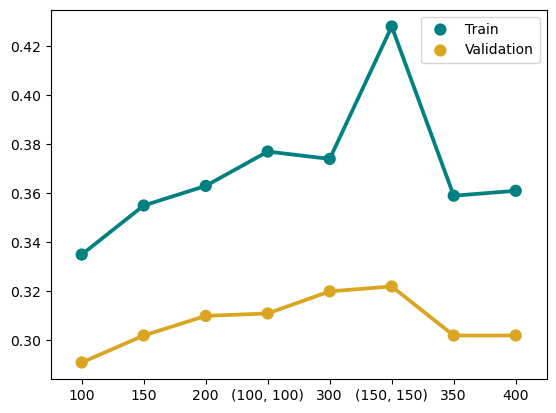

In [23]:
values_try = [(100),(150),(200),(100,100),(300),(150,150),(350),(400)]
results_train, results_val, names = get_models_nn(keep_data, values_try)
point_plot(results_train, results_val, names)

__CONCLUSION__:

- A small number of neurons in our Neural Network (one hidden layer with 100 neurons) usually leads to underfitting situations. <br>
- Increasing the number of layers or neurons, usually leads to overfitting situations. This is clear on the examples with two layers, namely (100,100) and (150,150).


Until this point, our optimization was done manually. But certain algorithms, such as Neural Networks, have a significant quantity of hyperparameters that could influence each other. In those cases, it can be useful to try different combinations of hyperparameters.

__OTHER IMPORTANT HYPERPARAMETERS:__

|Parameter| Definition | Options | Default | 
|---|---|---|---|
| solver| The solver for weight optimization. Lbfgs for small datasets. Adam for bigger datasets, can find a good result fast. In theory, sgd will a better solution but can take several iterations to achieve it. | _lbfgs_, _sgd_, _adam_ | _adam_ |
| learning_rate_init | The initial learning rate used. It controls the step-size in updating the weights. | _float_ | 0.001 | 
| learning_rate | How to decrease the learning rate over iterations. Constant keeps always the same value, invscaling changes the learning rate defined by a function at x steps, adaptive reduces the learning rate when the error is not decreasing. | _constant_, _invscaling_, _adaptive_ | _constant_| 
| activation | Activation function for the hidden layer. Logistic and tanh usually works better in classification problems. Relu is computationally more efficient.| _identity_, _logistic_, _tanh_, _relu_ | _relu_ |
| alpha | Strength of the L2 regularization term. Can be adjusted in overfitting situations.  | _float_ | 0.0001 |


<a class="anchor" id="9th-bullet">

### 4.2.4. RandomSearch
    
</a>

RandomizedSearchCV is a function provided by Scikit-learn (sklearn) that is used for hyperparameter tuning. While GridSearchCV exhaustively explores all possible combinations of hyperparameters, RandomizedSearchCV randomly samples a specified number of combinations from the parameter grid.

The random sampling of parameter combinations makes RandomizedSearchCV more efficient than GridSearchCV for large hyperparameter spaces. It allows you to define the number of iterations to control the search space exploration. RandomizedSearchCV selects the hyperparameter values randomly for each iteration and evaluates them using cross-validation.

Similar to GridSearchCV, RandomizedSearchCV returns the best set of hyperparameters based on a specified performance metric. The best hyperparameters can then be used to train a final model on the full dataset for making predictions.

RandomizedSearchCV is particularly useful when the hyperparameter search space is large and you want to explore a subset of it efficiently. It is a good choice when you have a limited computational budget or when you want to get a sense of the hyperparameter space before performing a more focused search using GridSearchCV.

__NOTE:__ RandomizedSearch do the process of cross validation inside the method itself. In this way, we are going to use the full data set and do all the needed changes and transformations on the data before applying the RandomizedSearch.

In theory, the best approach would be doing the needed changes inside the GridSearch, since we know that we want to use only information to fill missing data, scale the data, and so on. However, we are not be able to do this inside GridSearch without the usage of pipelines, which are not approached in this course.

__`Step 20`__ Create a copy of keep_data named as `data` and define the independent variables as `X_data` and the target as `y_data`. Transform the data as needed by calling the function `transform_data`. 

In [24]:
data = keep_data.copy()

X_data = data.drop(['DepVar'], axis = 1)
y_data = data['DepVar'].copy()

X_data = transform_data(X_train = X_data, X_2nd_df_flag = False)

__`Step 21`__ Create an instance of MLPClassifier named as `nn` with `max_iter = 2000` and `random_state = 99`.

In [25]:
nn = MLPClassifier(max_iter = 2000, random_state = 99)

__`Step 22`__ Define a dictionary named as __parameter_space_random__ and define the following options to be considered during modelling:
- 'hidden_layer_sizes': [(280),(290),(300),(310),(320)],
- 'learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
- 'learning_rate': ['constant', 'invscaling','adaptive'],
- 'solver': ['sgd','adam'],
- 'activation': ['logistic','relu']

In [26]:
parameter_space_random = {
    'hidden_layer_sizes': [(280),(290),(300),(310),(320)],
    'learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'invscaling','adaptive'],
    'solver': ['sgd','adam'],
    'activation': ['logistic','relu']
}

__`Step 23`__ Create an instance of RandomizedSearchCV named as __random_search__ and pass as parameters the model __nn__, the __parameter_space_random__, define `scoring = f1`, `cv = 5` and `random_state = 42`.

In [27]:
random_search = RandomizedSearchCV(nn, param_distributions=parameter_space_random, 
                                   scoring = 'f1', cv=5, random_state = 42)

__`Step 24`__ Fit your instance to __X_data__ and __y_data__. <br>
Call the attribute __best_params___ to check which is the best combination of parameters<br>
Call the attribute __best_score___ to obtain the mean cross-validated score of the best_estimator.

In [28]:
random_search.fit(X_data, y_data)

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", random_search.best_params_)
print("Best Score: ", random_search.best_score_)

Best Hyperparameters:  {'solver': 'adam', 'learning_rate_init': 0.01, 'learning_rate': 'adaptive', 'hidden_layer_sizes': 310, 'activation': 'logistic'}
Best Score:  0.38572433660014066


<a class="anchor" id="10th-bullet">

### 4.2.5. GridSearch
    
</a>



Another approach is using GridSearch that performs an exhaustive search over specified parameter values for an estimator. <br>
It is used for hyperparameter tuning, which involves finding the best combination of hyperparameters for a machine learning model.

To use GridSearchCV, you provide a parameter grid, which is a dictionary or a list of dictionaries containing the hyperparameters and their corresponding values to explore. The function then evaluates all possible combinations of hyperparameters using cross-validation. It trains and evaluates the model with each combination and returns the best set of hyperparameters that optimize a specified performance metric, such as accuracy or F1 score.

GridSearchCV systematically explores the entire parameter grid, making it computationally expensive for large grids or complex models. However, it ensures that you find the optimal hyperparameters by considering all possible combinations. Once you have the best hyperparameters, you can use them to train a final model on the full dataset for making predictions.

__`Step 25`__ Define a dictionary named as __parameter_space_grid__ and define the following options to be considered during modelling:
- 'hidden_layer_sizes': [(310)],
- 'learning_rate_init': [0.01, 0.005, 0.015],
- 'learning_rate': ['adaptive'],
- 'solver': ['adam'],
- 'activation': ['logistic]

In [29]:
parameter_space_grid = {
    'hidden_layer_sizes': [(310)],
    'learning_rate_init': [0.01, 0.005, 0.015],
    'learning_rate': ['adaptive'],
    'solver': ['adam'],
    'activation': ['logistic']
}

__`Step 26`__ Create an instance of GridSearchCV named as __grid_search__ and pass as parameters the model __nn__, the __parameter_space_grid__, define `scoring = f1` and `cv = 5`.

In [30]:
grid_search = GridSearchCV(nn, parameter_space_grid, scoring = 'f1', return_train_score = True, cv = 5)

__`Step 27`__ Fit your instance to __X_data__ and __y_data__. <br>
Call the attribute __best_params___ to check which is the best combination of parameters<br>
Call the attribute __best_score___ to obtain the mean cross-validated score of the best_estimator.

In [31]:
grid_search.fit(X_data, y_data)

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Hyperparameters:  {'activation': 'logistic', 'hidden_layer_sizes': 310, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'solver': 'adam'}
Best Score:  0.38572433660014066


__`Step 28`__ Create an instance of the model chosen for the algorithm MLPClassifier named as `final_model_nn`.

In [32]:
final_model_nn = MLPClassifier(activation = 'logistic', 
                               hidden_layer_sizes = (310), 
                               learning_rate = 'adaptive', 
                               learning_rate_init = 0.01, 
                               solver = 'adam', max_iter = 2000, random_state = 42)

<a class="anchor" id="11th-bullet">

### 4.2.6. Select the winner model
    
</a>

<a class="anchor" id="12th-bullet">

#### 4.2.6.1. COMPARE THE PERFORMANCE
    
</a>

Let's compare our final models:

__`Step 29`__ Compare the models using the function defined previoulsy `show_results`.

In [33]:
df_final_models = pd.DataFrame(columns = ['Train','Validation'], index = ['Best KNN','Best DT', 'Best NN'])
show_results(df_final_models, keep_data, final_model_knn, final_model_dt, final_model_nn)

,Train,Validation
Best KNN,0.448+/-0.02,0.269+/-0.07
Best DT,0.404+/-0.05,0.376+/-0.06
Best NN,0.389+/-0.04,0.35+/-0.06


<a class="anchor" id="13th-bullet">

#### __4.2.6.2. PLOT A ROC CURVE__
    
</a>

__`Step 30`__ Now we are going to compare our models using a ROC CURVE. To plot a ROC Curve, we need to create just one single model, and not several as we have when we apply StratifiedKFold.

Create a copy of `keep_data` as `data` and define your independent variables as `X_data` and your target as `y_data`.

In [34]:
data = keep_data.copy()

X_data = data.iloc[:,:-1]
y_data = data.iloc[:,-1]

__`Step 31`__ Split your dataset into train and validation using train_test_split, where `train_size = 0.8`, `random_state = 99` and `stratify = y_data`.

In [35]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, 
                                                  train_size = 0.8, 
                                                  random_state = 99, 
                                                  stratify = y_data)

__`Step 32`__ Apply the needed transformations by calling the `transform_data` function and fit your three models in the training data.

In [36]:
X_train, X_val = transform_data(X_train, X_val, X_2nd_df_flag = True)

model_knn = final_model_knn.fit(X_train, y_train)
model_dt = final_model_dt.fit(X_train, y_train)
model_nn = final_model_nn.fit(X_train, y_train)

__`Step 33`__ Use the `.predict_proba()` method of `modelknn` to obtain the probability estimates for the `X_val` and assign it to the object `prob_modelKNN`. Do the same for the other models, and assign it to `prob_modelDT` and `prob_modelNN`.

In [37]:
prob_modelKNN = model_knn.predict_proba(X_val)
prob_modelDT =  model_dt.predict_proba(X_val)
prob_modelNN =  model_nn.predict_proba(X_val)

__`Step 34`__ Call roc_curve() for the three different models. In this way, you should: <br>
1) For the first roc curve, call the roc_curve metric and define the arguments `y_true` equal to `y_val` and `y_score` equal to `prob_modelKNN[:, 1]`. Assign the results to `fpr_modelKNN`, `tpr_modelKNN` and `thresholds_modelKNN`. <br>
2) Repeat the same procedure to the remaining models, changing the names of the objects accordingly.

In [38]:
fpr_modelKNN, tpr_modelKNN, thresholds_modelKNN = roc_curve(y_true = y_val, y_score = prob_modelKNN[:,1])
fpr_modelDT, tpr_modelDT, thresholds_modelDT = roc_curve(y_val, prob_modelDT[:,1])
fpr_modelNN, tpr_modelNN, thresholds_modelNN = roc_curve(y_val, prob_modelNN[:,1])

__`Step 35`__ The purpose of this step is to plot the roc curve associated to each model. Do the following instructions in only one single cell, so the three roc curves appear in the same visualization. <br>
1) Create a plot using the function `plt.plot()`, where the data to be represented is going to be the `fpr_modelKNN`, `tpr_modelKNN`, and `label="ROC Curve KNN"` <br>
2) Similarly to the previous step, plot now the values regarding `modelDT` <br>
3) Similarly to the previous step, plot now the values regarding `modelNN` <br>
4) call the function plt.legend()
5) Call the function plt.show()

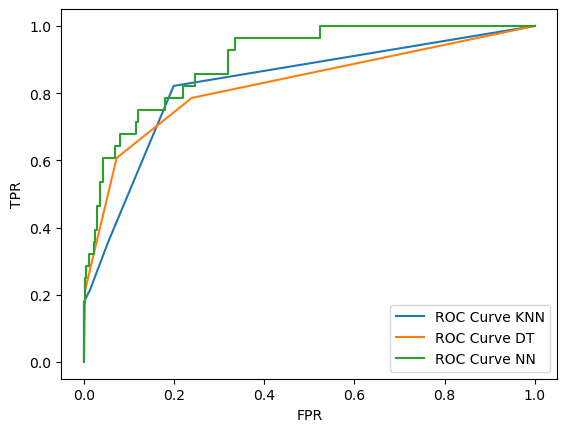

In [39]:
plt.plot(fpr_modelKNN, tpr_modelKNN,label="ROC Curve KNN")
plt.plot(fpr_modelDT, tpr_modelDT, label="ROC Curve DT")
plt.plot(fpr_modelNN, tpr_modelNN, label="ROC Curve NN")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

__CONCLUSION__ <br>
- The neural network seems to be the better model among the three tested algorithms.

<a class="anchor" id="14th-bullet">

#### 4.2.6.3. CHANGE THE THRESHOLD
    
</a>

At this point, you already know which are the best hyperparameters of your best model. <br>
The last thing you can try out to improve the performance of your model is to change the threshold of what you consider a positive prediction vs a negative prediction. <br>
By default, that threshold is 0.5, i.e., observations where the probability of being 1 is equal or higher to 0.5 are considered positive, otherwise negative.

Like we did to plot the ROC Curve, in this case we are just going to use one partition, provided by the train_test_split on `Step 31.`


__`Step 36`__ Fit your final model to the training data.

In [40]:
final_model = final_model_nn.fit(X_train, y_train)

__`Step 37`__ Calculate the probabilities associated with each observation in X_val being of class 0 or 1.

In [41]:
predict_proba = final_model.predict_proba(X_val)
predict_proba

array([[9.98986902e-01, 1.01309832e-03],
       [7.47563389e-01, 2.52436611e-01],
       [9.94302989e-01, 5.69701051e-03],
       [9.99194954e-01, 8.05046169e-04],
       [9.88891182e-01, 1.11088175e-02],
       [9.96840465e-01, 3.15953520e-03],
       [9.81067398e-01, 1.89326019e-02],
       [9.66283985e-01, 3.37160150e-02],
       [9.90436568e-01, 9.56343220e-03],
       [9.97560334e-01, 2.43966614e-03],
       [9.94094129e-01, 5.90587132e-03],
       [9.97558045e-01, 2.44195544e-03],
       [9.37338168e-01, 6.26618318e-02],
       [9.32387170e-01, 6.76128300e-02],
       [9.96962097e-01, 3.03790343e-03],
       [9.98084595e-01, 1.91540538e-03],
       [9.93345730e-01, 6.65427007e-03],
       [9.94095980e-01, 5.90401985e-03],
       [8.22408658e-01, 1.77591342e-01],
       [9.93369359e-01, 6.63064090e-03],
       [9.33431550e-01, 6.65684497e-02],
       [1.83697054e-01, 8.16302946e-01],
       [9.95860188e-01, 4.13981162e-03],
       [9.97666485e-01, 2.33351535e-03],
       [9.515900

__`Step 38`__ The purpose of this step is to plot the precision recall curve associated to the best model. <br>
1) Import precision_recall_curve from sklearn.metrics<br>
2) Get the precision, the recall and the thresholds from your precision recall curve<br>
3) Check what is the threshold for the best f1 score<br>
4) Plot the precision recall curve and the best threshold.<br>

Best Threshold=0.246886, F-Score=0.557


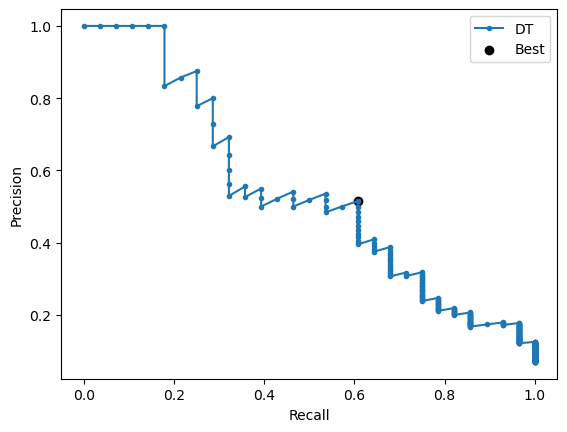

In [42]:
precision, recall, thresholds = precision_recall_curve(y_val, predict_proba[:,1])

# apply f1 score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

plt.plot(recall, precision, marker='.', label='DT')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

__CONCLUSION__ <br>
- By changing the threshold to 0.246886, we are able to improve the f1-score of our final model.

<a class="anchor" id="15th-bullet">

# 5. Deploy

</a>
<img src="Images/step5.png" style="height:70px">


You used the previous steps of modelling and assessment to determine what would be best strategies when it comes to preprocessing, scaling, feature selection, algorithm and hyper-parameters you could find. 

**By this stage, all of those choices were already made**. For that reason, a split between training and validation is no longer necessary. **A good practice** would be to take the initial data and train a final model with all of the labeled data that you have available.

In [43]:
train = keep_data.copy()

X_train = keep_data.drop(['DepVar'], axis = 1)
y_train = keep_data['DepVar']

**Everything is figured by this stage**, so, on a first level all you need to do is replicate the exact preprocessing, scaling and feature selection decisions you made before.<br>
When it comes to the final model, all you have to do is creeate a new instance of your best algorithm with the best parameters that you uncovered (no need to try all algorithms and hyper-parameters again).

<div class="alert alert-block alert-success">

<a class="anchor" id="16th-bullet">

## 5.1. Import your test data and apply transformations
    
</a>
    
</div>

__`Step 39`__ Remember, the test data does not have the `outcome` variable.

In [44]:
test = pd.read_excel(r'Data/test.xlsx')
test = test[['Custid','Mnt','Clothes','NetPurchase','Marital_Status']].copy() # now we have all the columns needed
test.set_index(['Custid'], inplace = True)

In [45]:
test

,Mnt,Clothes,NetPurchase,Marital_Status
Custid,,,,
7770,449.28,88,56,Married
3170,1335.36,9,11,Together
10875,1659.84,47,21,Together
6213,683.28,94,59,Married
4345,19.76,24,45,Single
...,...,...,...,...
10369,123.76,41,57,Married
7361,122.72,16,46,Single
2278,19.76,23,42,Single


__`Step 40`__ Apply all the needed transformations in your training data and your test data.

In [46]:
train, test = transform_data(X_train, test, X_2nd_df_flag = True)

__`Step 41`__ Train your final model in the training data.

In [47]:
final_model = final_model_nn.fit(train, y_train)

<div class="alert alert-block alert-success">

<a class="anchor" id="17th-bullet">

## 5.2. Obtain Predictions on the test data from your final model
    
</a>
    
</div>

__`Step 42`__ Obtain the predictions of the probabilities of your final model in the test data. by calling the method `predict_proba()`.

In [48]:
final_model.predict(test) # the method predict() will predict the classes of your target when the threshold = 0.5

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [49]:
predict_proba_test = final_model.predict_proba(test)
predict_proba_test

array([[9.86112018e-01, 1.38879818e-02],
       [9.73137026e-01, 2.68629744e-02],
       [8.74405609e-01, 1.25594391e-01],
       [9.72367679e-01, 2.76323207e-02],
       [9.99373729e-01, 6.26270781e-04],
       [6.97249589e-01, 3.02750411e-01],
       [9.85920308e-01, 1.40796917e-02],
       [9.98710293e-01, 1.28970697e-03],
       [7.20362433e-01, 2.79637567e-01],
       [9.82204293e-01, 1.77957070e-02],
       [9.83078618e-01, 1.69213823e-02],
       [8.18165387e-01, 1.81834613e-01],
       [9.77235782e-01, 2.27642181e-02],
       [9.95056439e-01, 4.94356137e-03],
       [9.96713049e-01, 3.28695116e-03],
       [9.64602015e-01, 3.53979851e-02],
       [9.78535674e-01, 2.14643263e-02],
       [9.69059667e-01, 3.09403335e-02],
       [9.92012660e-01, 7.98734000e-03],
       [9.97795777e-01, 2.20422268e-03],
       [9.99550254e-01, 4.49746339e-04],
       [9.92022327e-01, 7.97767268e-03],
       [9.09229398e-01, 9.07706016e-02],
       [9.99501874e-01, 4.98126287e-04],
       [9.967690

__`Step 43`__ Define your final predictions, by changing the threshold of what is accepted as 1 and as 0. 

In [50]:
final_pred = []

for value in predict_proba_test[:,1]:
    if (value>=0.246886):
        final_pred.append(1)
    else:
        final_pred.append(0)

final_pred

[0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


<div class="alert alert-block alert-success">

<a class="anchor" id="18th-bullet">

## 5.3. Create a Dataframe containing the index of each row and its intended prediction and export it to a csv file
    
</a>
    
</div>

__`Step 44`__ Create a new DataFrame, and add as column `Custid` the values of the `Custid` for each customer in the test data set, and a column named `DepVar` where you will store the preditions of your final model in the test data. Save those results in a .csv file.

In [51]:
answer = pd.DataFrame()
answer['Custid'] = test.index
answer['DepVar'] = final_pred
answer.head(20)

,Custid,DepVar
0,7770,0
1,3170,0
2,10875,0
3,6213,0
4,4345,0
5,10407,1
6,4150,0
7,1555,0
8,5664,1
9,9408,0


In [52]:
answer.to_csv('answer.csv', index = False)